In [28]:
# import dependencies
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plotty
import missingno as msno

from scipy import stats

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
# !pip install catboost
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# suppress ugly warning messages
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


# Lambdas
days_since = lambda x: x - df.time_stamp.min()
remove_whitespace = lambda x: x.replace(" ", "")
# log = lambda x: np.log(x)

# Data Preparation

In [29]:
# price_paid               int64 [233500, 270000, 176000, 450000, 440000]
# money, possibly look into normalizing
# deed_date               object ['05/07/2017', '05/07/2017', '05/07/2017', '05/07/2017', '05/07/2017']
# date object convert to timestamp and then add days since value
# property_type           object ['F', 'T', 'O', 'S', 'D']
# categorical data perform label encoder
# new_build               object ['N', 'Y']
# categorical data perform label encoder
# estate_type             object ['L', 'F']
# categorical data perform label encoder
# district                object ['TOWER HAMLETS', 'CITY OF LONDON', 'HACKNEY', 'HARROW', 'WALTHAM FOREST']
# categorical data perform label encoder
# transaction_category    object ['A', 'B']
# categorical data perform label encoder

In [30]:
# Load the datasets
pricing_df = pd.read_csv('../data/raw/01_06_2014_until_04_06_2019.csv')
# We can load the 1gb master csv of postcode data into memory with pandas
postcode_df = pd.read_csv('../data/raw/NSPL_MAY_2019_UK.csv', low_memory=False)

In [31]:
pricing_df.postcode = pricing_df.postcode.astype(str).map(remove_whitespace)
postcode_df.pcd = postcode_df.pcd.astype(str).map(remove_whitespace)

In [288]:
# Merging the datasets to bring in lat and lon values.
left = pricing_df
right = postcode_df
df = pd.merge(left, right, how='left', left_on='postcode', right_on='pcd')
# Drop the rows that have NaN in lat or long column
df = df.dropna(subset=['lat'])
df = df.dropna(subset=['long'])
df.shape

(343135, 57)

In [33]:
# Split by Boroughs of interest
lewisham = df.loc[df['district'] == 'LEWISHAM']
croydon = df.loc[df['district'] == 'CROYDON']
kensington_chelsea = df.loc[df['district'] == 'KENSINGTON AND CHELSEA']
westminster = df.loc[df['district'] == 'CITY OF WESTMINSTER']

In [34]:
# Check for duplicate values
df.duplicated().any()

False

In [35]:
lewisham.shape

(20213, 57)

In [36]:
df = westminster
# remove property type other
df = df.loc[df['property_type'] != 'O']
# Remove outliers in price
df = df.loc[(df['price_paid'] < (1000000)) & (df['price_paid'] > (10000))]
# Convert the date object type to... timestamp
df['time_stamp'] = pd.to_datetime(df['deed_date'])
# Create features for year and month
df['year'] = df['time_stamp'].dt.year
df['month'] = df['time_stamp'].dt.month
# apply the lambda on time_stamp, writing to new column
df['days_since'] = df['time_stamp'].map(days_since)
# encode the 'days since' and write to new column
df['days_since'] = df['days_since'].dt.days
# Setting the index to timestamp for time series operations
df.index = df['time_stamp']
# Dropping unnecessary column
df.drop(['time_stamp'], axis=1)
# round to the nearest thousand £
df['price_paid'] = df['price_paid'].round(decimals=3)
# df.drop(['unique_id', 'paon', 'saon', 'linked_data_url', 'street', 'locality', 'county', 'town', 'postcode'], axis=1)
df['property_type_encoded'] = df[['property_type']].apply(preprocessing.LabelEncoder().fit_transform)
df['new_build_encoded'] = df[['new_build']].apply(preprocessing.LabelEncoder().fit_transform)
df['estate_type_encoded'] = df[['estate_type']].apply(preprocessing.LabelEncoder().fit_transform)
df['transaction_category_encoded'] = df[['transaction_category']].apply(preprocessing.LabelEncoder().fit_transform)
# Selecting columns for modelling
df = df[['price_paid', 'lat','long','year','month','days_since','property_type_encoded','new_build_encoded','estate_type_encoded','transaction_category_encoded']]
westminster_prep = df
westminster_prep.shape

(8224, 10)

In [37]:
df = kensington_chelsea
# remove property type other
df = df.loc[df['property_type'] != 'O']
# Remove outliers in price
df = df.loc[(df['price_paid'] < (1000000)) & (df['price_paid'] > (10000))]
# Convert the date object type to... timestamp
df['time_stamp'] = pd.to_datetime(df['deed_date'])
# Create features for year and month
df['year'] = df['time_stamp'].dt.year
df['month'] = df['time_stamp'].dt.month
# apply the lambda on time_stamp, writing to new column
df['days_since'] = df['time_stamp'].map(days_since)
# encode the 'days since' and write to new column
df['days_since'] = df['days_since'].dt.days
# Setting the index to timestamp for time series operations
df.index = df['time_stamp']
# Dropping unnecessary column
df.drop(['time_stamp'], axis=1)
# round to the nearest thousand £
df['price_paid'] = df['price_paid'].round(decimals=3)
# df.drop(['unique_id', 'paon', 'saon', 'linked_data_url', 'street', 'locality', 'county', 'town', 'postcode'], axis=1)
df['property_type_encoded'] = df[['property_type']].apply(preprocessing.LabelEncoder().fit_transform)
df['new_build_encoded'] = df[['new_build']].apply(preprocessing.LabelEncoder().fit_transform)
df['estate_type_encoded'] = df[['estate_type']].apply(preprocessing.LabelEncoder().fit_transform)
df['transaction_category_encoded'] = df[['transaction_category']].apply(preprocessing.LabelEncoder().fit_transform)
# Selecting columns for modelling
df = df[['price_paid', 'lat','long','year','month','days_since','property_type_encoded','new_build_encoded','estate_type_encoded','transaction_category_encoded']]
kensington_chelsea_prep = df
kensington_chelsea_prep.shape

(4193, 10)

In [203]:
df = croydon
# remove property type other
df = df.loc[df['property_type'] != 'O']
# Remove outliers in price
df = df.loc[(df['price_paid'] < (1000000)) & (df['price_paid'] > (10000))]
# Convert the date object type to... timestamp
df['time_stamp'] = pd.to_datetime(df['deed_date'])
# Create features for year and month
df['year'] = df['time_stamp'].dt.year
df['month'] = df['time_stamp'].dt.month
# apply the lambda on time_stamp, writing to new column
df['days_since'] = df['time_stamp'].map(days_since)
# encode the 'days since' and write to new column
df['days_since'] = df['days_since'].dt.days
# Setting the index to timestamp for time series operations
df.index = df['time_stamp']
# Dropping unnecessary column
df.drop(['time_stamp'], axis=1)
# round to the nearest thousand £
df['price_paid'] = df['price_paid'].round(decimals=3)
# df.drop(['unique_id', 'paon', 'saon', 'linked_data_url', 'street', 'locality', 'county', 'town', 'postcode'], axis=1)
df['property_type_encoded'] = df[['property_type']].apply(preprocessing.LabelEncoder().fit_transform)
df['new_build_encoded'] = df[['new_build']].apply(preprocessing.LabelEncoder().fit_transform)
df['estate_type_encoded'] = df[['estate_type']].apply(preprocessing.LabelEncoder().fit_transform)
df['transaction_category_encoded'] = df[['transaction_category']].apply(preprocessing.LabelEncoder().fit_transform)
# Selecting columns for modelling
croydon_prep = df[['price_paid', 'lat','long','year','month','days_since', 'property_type_encoded','new_build_encoded','estate_type_encoded','transaction_category_encoded']]
croydon_averages = df[['price_paid', 'lat','long','year','month','days_since', 'property_type', 'property_type_encoded','new_build_encoded','estate_type_encoded','transaction_category_encoded']]
croydon_averages.shape

(5237, 11)

In [39]:
df = lewisham
# remove property type other
df = df.loc[df['property_type'] != 'O']
# Remove outliers in price
df = df.loc[(df['price_paid'] < (1000000)) & (df['price_paid'] > (10000))]
# Convert the date object type to... timestamp
df['time_stamp'] = pd.to_datetime(df['deed_date'])
# Create features for year and month
df['year'] = df['time_stamp'].dt.year
df['month'] = df['time_stamp'].dt.month
# apply the lambda on time_stamp, writing to new column
df['days_since'] = df['time_stamp'].map(days_since)
# encode the 'days since' and write to new column
df['days_since'] = df['days_since'].dt.days
# Setting the index to timestamp for time series operations
df.index = df['time_stamp']
# Dropping unnecessary column
df.drop(['time_stamp'], axis=1)
# round to the nearest thousand £
df['price_paid'] = df['price_paid'].round(decimals=3)
# df.drop(['unique_id', 'paon', 'saon', 'linked_data_url', 'street', 'locality', 'county', 'town', 'postcode'], axis=1)
df['property_type_encoded'] = df[['property_type']].apply(preprocessing.LabelEncoder().fit_transform)
df['new_build_encoded'] = df[['new_build']].apply(preprocessing.LabelEncoder().fit_transform)
df['estate_type_encoded'] = df[['estate_type']].apply(preprocessing.LabelEncoder().fit_transform)
df['transaction_category_encoded'] = df[['transaction_category']].apply(preprocessing.LabelEncoder().fit_transform)
# Selecting columns for modelling
df = df[['price_paid', 'lat','long','year','month','days_since','property_type_encoded','new_build_encoded','estate_type_encoded','transaction_category_encoded']]
lewisham_prep = df
lewisham_prep.shape

(19076, 10)

In [40]:
# df
# df['price_paid','property_type','new_build', 'estate_type','transaction_category',
#        'lat', 'long', 'time_stamp', 'year', 'month', 'days_since',
#     'property_type_encoded', 'new_build_encoded',
#        'estate_type_encoded', 'transaction_category_encoded']

In [41]:
# dfs = [lewisham_prep, kensington_chelsea_prep, westminster_prep, croydon_prep]
# results = []

# for d in dfs:
#     shape = d.shape
#     results.append(shape)

# print(results)

In [42]:
# df = lewisham_prep.sample(1000, random_state=1)

In [43]:
# df = df[['price_paid', 'lat','long','year','month','days_since','property_type_encoded','new_build_encoded','estate_type_encoded','transaction_category_encoded']]
# df.dropna()
# df.isna().any()
df = lewisham_prep
# df.to_pickle('../data/processed/lewisham_prep.pkl')
# df = kensington_chelsea_prep
# df = croydon_prep
# df = westminster_prep
# df
# corr = d.corr()
# corr.style.background_gradient(cmap='coolwarm')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1956106a0>,
      dtype=object)

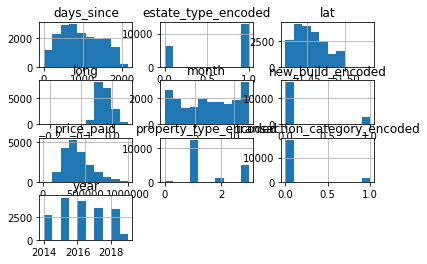

In [44]:
# subset - district days since time series latlon outliers removed
df.hist()

In [45]:
# import seaborn as sns
# sns.set()
# dfe = df.resample('M').mean()
# plotty.plot(df)
# plotty.title('Average Price Per Month')
# plotty.ylabel('Average Price')
# plotty.xticks(rotation=45)
# plotty.show()

In [46]:
# df = df.price_paid.map(log)

In [132]:
kensington_chelsea_prep.to_pickle('../data/processed/kensington_chelsea_prep.pkl')

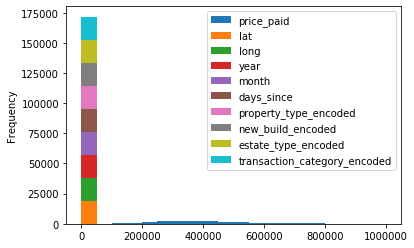

In [52]:
# df.plot.hist(stacked=True, bins=20)
# df = df['price_paid'].map(log)
# d = df.sample(1000)
# plotty.scatter(d['price_paid'], d['days_since'], color='blue')
# plotty.title('Price paid vs Deed Date', fontsize=14)
# plotty.xlabel('Price Paid', fontsize=14)
# plotty.ylabel('Days since', fontsize=14)
# # plotty.grid(True)
# plotty.show()
# d.plot(figsize=(18,5))

# Comparing Various Models

In [116]:
df = croydon_prep
# Split data into predictors X and output Y
predictors = ['lat','long','year','month','days_since','property_type_encoded','new_build_encoded','estate_type_encoded','transaction_category_encoded']
X = df[predictors]
y = df['price_paid']
# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
models = []

models.append(('LR', LinearRegression()))
models.append(('XGB', XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.08, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.75)))
# models.append(('CTB', CatBoostRegressor()))
# models.append(('CTB', CatBoostRegressor(learning_rate=1, depth=6, loss_function='r2')))
# models.append(('PER', Perceptron()))
# models.append(('LA', Lasso()))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('RFR', RandomForestRegressor(n_estimators=40, n_jobs=-1)))
# models.append(('GPR', GaussianProcessRegressor()))
# models.append(('SVR', SVR()))
models.append(('ABR', AdaBoostRegressor()))

# evaluate each model in turn
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    # Evaluate the performance of the algorithm with metrics
    # Mean Absolute Error
    mae = metrics.mean_absolute_error(y_test, y_pred)
    # Mean Squared Error
    mse = metrics.mean_squared_error(y_test, y_pred)
    # Root Mean Squared Error
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    msg = "%s: %f, mae: %f, mse: %f, rmse: %f" % (name, score, mae, mse, rmse)
    print(msg)


LR: 0.600443, mae: 66492.085989, mse: 8137926141.935474, rmse: 90210.454726


/Users/david.maceachern/.pyenv/versions/3.7.0/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGB: 0.695325, mae: 55074.366621, mse: 6205442105.063156, rmse: 78774.628562
DTR: 0.458814, mae: 74372.490776, mse: 11022548621.985313, rmse: 104988.326122
RFR: 0.671116, mae: 56742.191053, mse: 6698500542.597413, rmse: 81844.367812
ABR: 0.547001, mae: 73895.227286, mse: 9226401370.220848, rmse: 96054.158526


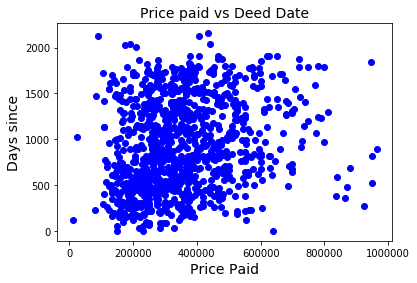

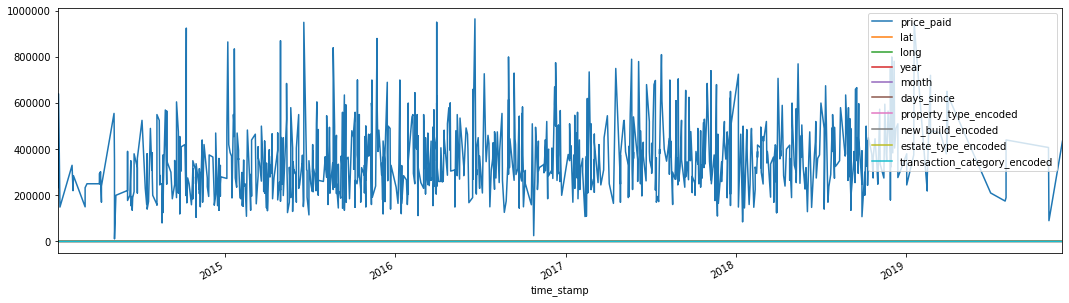

In [65]:
df = croydon_prep
d = df.sample(1000)
plotty.scatter(d['price_paid'], d['days_since'], color='blue')
plotty.title('Price paid vs Deed Date', fontsize=14)
plotty.xlabel('Price Paid', fontsize=14)
plotty.ylabel('Days since', fontsize=14)
# plotty.grid(True)
plotty.show()
d.plot(figsize=(18,5))

fig, axs = plotty.subplots(2, 2, figsize=(10, 10))
df = croydon_prep
d = df.sample(1000, random_state=1)
axs[0, 0].scatter(d['days_since'], d['price_paid'], color='blue', alpha=0.3)
axs[0, 0].title.set_text('Croydon')
df = lewisham_prep
d = df.sample(1000, random_state=1)
axs[0, 1].scatter(d['days_since'], d['price_paid'], color='blue', alpha=0.3)
axs[0, 1].title.set_text('Lewisham')
df = kensington_chelsea_prep
d = df.sample(1000, random_state=1)
axs[1, 0].scatter(d['days_since'], d['price_paid'], color='blue', alpha=0.3)
axs[1, 0].title.set_text('Kensington and Chelsea')
df = westminster_prep
d = df.sample(1000, random_state=1)
axs[1, 1].scatter(d['days_since'], d['price_paid'], color='blue', alpha=0.3)
axs[1, 1].title.set_text('Westminster')
fig.tight_layout()
plotty.show()

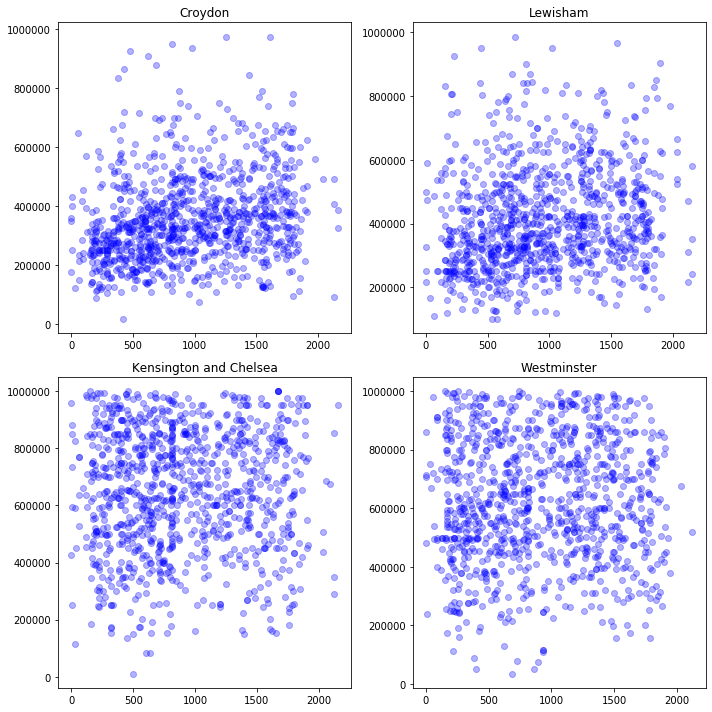

In [152]:
fig, axs = plotty.subplots(2, 2, figsize=(10, 10))
df = croydon_prep
d = df.sample(1000, random_state=1)
axs[0, 0].scatter(d['days_since'], d['price_paid'], color='blue', alpha=0.3)
axs[0, 0].title.set_text('Croydon')
df = lewisham_prep
d = df.sample(1000, random_state=1)
axs[0, 1].scatter(d['days_since'], d['price_paid'], color='blue', alpha=0.3)
axs[0, 1].title.set_text('Lewisham')
df = kensington_chelsea_prep
d = df.sample(1000, random_state=1)
axs[1, 0].scatter(d['days_since'], d['price_paid'], color='blue', alpha=0.3)
axs[1, 0].title.set_text('Kensington and Chelsea')
df = westminster_prep
d = df.sample(1000, random_state=1)
axs[1, 1].scatter(d['days_since'], d['price_paid'], color='blue', alpha=0.3)
axs[1, 1].title.set_text('Westminster')
fig.tight_layout()
plotty.show()

In [287]:
df = croydon_averages[croydon_averages['property_type'] == 'T']
# _2014 = df['2014']
# _2015 = df['2015']
# _2016 = df['2015']
# _2017 = df['2016']
# _2018 = df['2017']
# _2019 = df['2018']
# _2019 = df['2019']

# _2014 = _2014.groupby('month').price_paid.agg(['mean']).reset_index()
# _2015 = _2015.groupby('month').price_paid.agg(['mean']).reset_index()
# _2016 = _2016.groupby('month').price_paid.agg(['mean']).reset_index()
# _2017 = _2017.groupby('month').price_paid.agg(['mean']).reset_index()
# _2018 = _2018.groupby('month').price_paid.agg(['mean']).reset_index()
# _2019 = _2019.groupby('month').price_paid.agg(['mean']).reset_index()

# plotty.plot(_2014["month"], _2014['mean'], color='red', alpha=0.1, label="2014")
# plotty.plot(_2015["month"], _2015['mean'], color='purple', alpha=0.3, label="2015")
# plotty.plot(_2016["month"], _2016['mean'], color='green', alpha=0.5, label="2016")
# plotty.plot(_2017["month"], _2017['mean'], color='yellow', alpha=0.7, label="2017")
# plotty.plot(_2018["month"], _2018['mean'], color='pink', alpha=0.9, label="2018")
# plotty.plot(_2019["month"], _2019['mean'], color='blue', alpha=1.1, label="2019")
# # Place a legend to the right of this smaller subplot.
# plotty.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plotty.show()

KeyError: ('price_paid', 'lat')

In [ ]:
# Resample to monthly frequency and plot 
df2 = croydon_averages['price_paid', 'lat'].set_index('time_stamp').resample('M').mean()
